In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats

In [145]:
SP = pd.read_csv('data/SnP500.csv').dropna()
SP.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
23278,2020-09-02,3543.760010,3588.110107,3535.229980,3580.840088,3580.840088,4285190000
23279,2020-09-03,3564.739990,3564.850098,3427.409912,3455.060059,3455.060059,4898680000
23280,2020-09-04,3453.600098,3479.149902,3349.629883,3426.959961,3426.959961,4431440000
23281,2020-09-08,3371.879883,3379.969971,3329.270020,3331.840088,3331.840088,4665600000
23282,2020-09-09,3369.820068,3424.770020,3366.840088,3398.959961,3398.959961,3920830000


In [146]:
# SP.rename(columns={'GOLDAMGBD228NLBM': 'Close'}, inplace=True)
# SP.Close = SP.Close.apply(pd.to_numeric, errors='coerce')
# SP.Close = SP.Close.fillna(method='ffill')

In [147]:
SP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23283 entries, 0 to 23282
Data columns (total 7 columns):
Date         23283 non-null object
Open         23283 non-null float64
High         23283 non-null float64
Low          23283 non-null float64
Close        23283 non-null float64
Adj Close    23283 non-null float64
Volume       23283 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.3+ MB


In [148]:
i = 1
f = [1, 2]

for i in range(15):
    i = f[-1] + f[-2]
    f.append(i)
    
print(f)

[1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584]


In [149]:
df = []

#с конца всего датасета
for i in range(5000):
    period_pred = 30
    chnd = (SP.Close.iloc[-2 - i - period_pred]/SP.Close.iloc[-1 - i] - 1)*100
    row = []
    if chnd < -10:
        row.append(1)
    else:
        row.append(0)
    for j in (2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610):
        row.append(SP.Close.iloc[-j - i - period_pred])
    df.append(row)



In [150]:
df = pd.DataFrame(df)
df.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
4995,0,1465.810059,1480.869995,1481.98999,1502.510010,1502.589966,1491.719971,1438.099976,1454.599976,1420.959961,1353.430054,1254.130005,1268.589966,1126.670044
4996,0,1480.869995,1484.910034,1489.26001,1492.250000,1509.839966,1496.069946,1430.829956,1442.390015,1407.810059,1360.689941,1247.410034,1262.140015,1123.650024
4997,0,1484.910034,1481.989990,1494.50000,1507.079956,1514.089966,1479.849976,1419.890015,1454.819946,1383.050049,1352.170044,1283.420044,1297.010010,1122.719971
4998,0,1481.989990,1489.260010,1502.51001,1520.770020,1506.449951,1484.430054,1449.619995,1450.550049,1412.140015,1346.089966,1285.550049,1299.290039,1108.170044
4999,0,1489.260010,1494.500000,1492.25000,1517.680054,1508.310059,1491.560059,1452.420044,1455.310059,1424.170044,1388.260010,1313.040039,1316.550049,1119.319946


In [153]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, classification_report, precision_recall_curve, confusion_matrix

In [154]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['0'], 1), df['0'], random_state=0)

In [155]:
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    

continuous_columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]

In [156]:
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# preds = rf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_true=y_test, y_score=preds)
fscore = (2 * precision/50 * recall) / (precision/50 + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_true=y_test, y_score=preds)
print(roc_auc)

Best Threshold=0.753, F-Score=0.743, Precision=0.765, Recall=0.722
Best Threshold=0.983, F-Score=0.037, Precision=1.000, Recall=0.278
0.9925369769119768


In [157]:
y_test.value_counts(normalize=True)

0    0.9856
1    0.0144
Name: 0, dtype: float64

In [158]:
preds = pipeline.predict_proba(df.drop(['0'], 1))[:, 1]
preds

array([0.00091626, 0.00091626, 0.00091626, ..., 0.00078029, 0.00078029,
       0.00078029])

In [159]:
len(preds)

5000

In [160]:
np.array(y_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

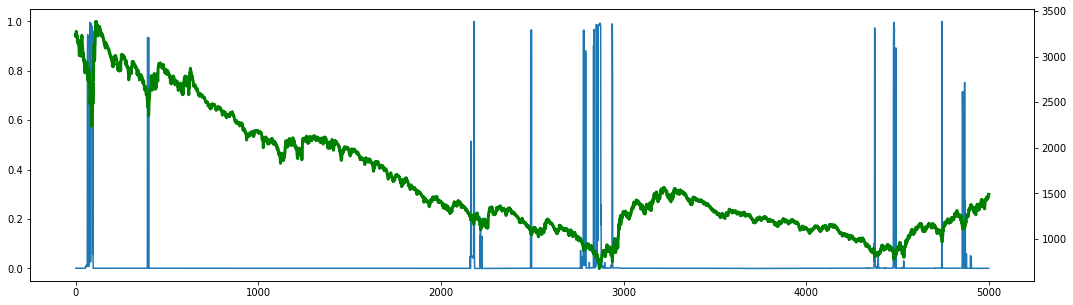

In [161]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(18, 5)
lns1 = ax.plot(preds)
ax2 = ax.twinx()
lns2 = ax2.plot(df['1'], linewidth=3, c='g', label='y')
lns = lns1+lns2
plt.show()

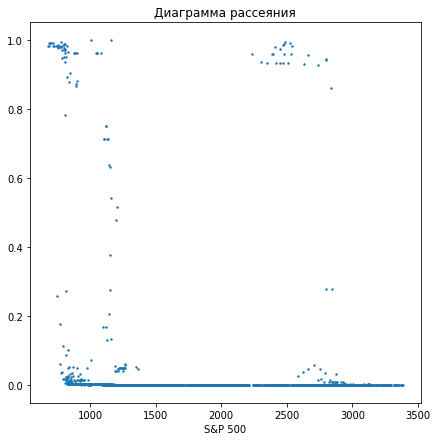

-0.062472745052038356

In [162]:
plt.figure(figsize=(7,7))
plt.scatter(df['1'], preds, s=2)
plt.title('Диаграмма рассеяния')
plt.xlabel('S&P 500')
# plt.ylabel('казначейские облигации')
plt.show()
df['1'].corr(pd.Series(preds))
